## (Optional) Homework 5: Using and Finetuning Pretrained Language Models
### LING 380/780 Neural Network Models of Linguistic Structure 
#### Not Due

In this last (optional) homework, you will get experience in using and finetuning pretrained language models. 


### Part 1: Exploring Pretrained Models

To begin, wou will need to install the Hugging Face `transformers` library, which provides a simple API for loading and using pretrained models with `pytorch`. You can do this by running the following command at the command line:

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


To begin, we will import a number of relevant packages:

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from matplotlib import interactive
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Next, we will load a pretrained language model. We will begin with the basic `gpt2` model, a decoder-only transformer model that has 124M parameters. (Note that the huggingface also includes larger versions of the [GPT2 model](https://huggingface.co/openai-community/gpt2) as well as many other language models, which you are free to use and explore -- these will be downloaded to your computer when you run this code, so be certain that you have enough disk space for the models you use.)  

To begin, we need to load two components: a tokenizer and the model itself. We do this with the following two commands:

In [3]:
model_name = 'openai-community/gpt2'
#model_name = 'facebook/xglm-564M'
#model_name = 'ai-forever/mGPT'
#model_name = 'meta-llama/Llama-3.2-1B'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/anaconda3/envs/babylm_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/babylm_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /opt/anaconda3/envs/babylm_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <5164AED8-BCBA-3135-84A9-0FCFD7EB4516> /opt/anaconda3/envs/babylm_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/envs/babylm_env/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The tokenizer is used to convert text into a format that the model can understand. Specifically, it converts text into a sequence of integers, where each one corresponds to an element in the model's vocabulary. For the models we will be using, the elements of the vocabulary do not necessarily correspond to complete words. While this will be the case for frequent words (where a word is defined as a sequence of characters surrounded by spaces), other words will be broken into subword tokens. Tokens that begin at the beginning of a word are marked with a special character (which is Ġ for GPT-2, and ▁ for other models), so that they are distinguished from a word subpart. The choice of subword tokens is determined by the [Byte Pair Encoding (BPE) algorithm](https://en.wikipedia.org/wiki/Byte_pair_encoding), which begins with a vocabulary of single characters and then iteratively merges the most frequent pairs of characters (as determined by the training data, or a sample thereof) until the vocabulary reaches a desired size. The tokenizer works by greedily finding the longest token in the vocabulary that matches the beginning of the next word in the input. 

The use of subword tokenization ensures that all input sequences can be turned into sequences of known vocabulary items. Such subword tokenization is particularly useful in the case of languages with rich morphology, since it allows the model to generalize to forms that may not have occurred in the training data. (A single verb in Finnish can have thousands of distinct forms, and having a vocabulary that included all of them would not be feasible.) 

For GPT-2, the tokenizer we are using includes approximately 50K vocabulary items.

In [4]:
len(tokenizer)

50257

We begin by defining a simple sentence, appending a special token to its beginning which indicates the start of the sentence. We then use the tokenizer to convert the sentence into a sequence of integers. (Note that tokenizers for many add the beginning of sentence token themselves, so we will not always need to do this manually.)

In [5]:
input = tokenizer.bos_token + " " + "The capital of Germany is called"
encoded_input = tokenizer(input, return_tensors='pt')

encoded_input

{'input_ids': tensor([[50256,   383,  3139,   286,  4486,   318,  1444]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

The `encoded_input` is a Python dictionary with two entries: `input_ids` contains the sequence of subword tokens, and `attention_mask` is a binary mask that indicates which tokens are actual input tokens and which are padding tokens. (In this case, we have no padding tokens, so the mask is all 1s.) We can use the `convert_ids_to_tokens` method of the tokenizer to see how the input sequence has been decomposed into subword tokens.

In [6]:
tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])

['<|endoftext|>', 'ĠThe', 'Ġcapital', 'Ġof', 'ĠGermany', 'Ġis', 'Ġcalled']

We can now pass the `encoded_input` to the model to get its output. Since we used the `AutoModelForCausalLM` class to load the model, we are using a model that has been pretrained for language modeling. (The `AutoModel` class includes methods that can be used to load models that have been pretrained for other tasks, including classification or question answering.) The `output` of the model provides a number of objects, including the `loss` (negative log likelihood per word) associated with the input (this is why we provided the `labels` as input) as well as the `logits` associated with each token in the input sequence. `logits` is a tensor of shape `(batch_size, sequence_length, vocab_size)` and each value is the raw output of the model. 

In [7]:
output = model(**encoded_input, labels=encoded_input["input_ids"])

As you will see, some of the values of these elements (e.g., `hidden_states` and `attentions`) are `None`. If you want the model to return these values, you can set the `output_hidden_states` and `output_attentions` arguments to `True` when you load the model (the values of these arguments will be tuples, one for each layer of the transformer):

In [8]:
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             return_dict_in_generate=True,      
                                             output_attentions=True, 
                                             output_hidden_states=True)

Putting aside hidden states and attentions for the moment, we can convert the `logits` into probabilities by applying the `softmax` function (log probabilities can be obtained with the `log_softmax` function). If we take the softmax over the values only at the last position in the sequence, we will get a tensor of shape `(batch_size, vocab_size)` where each value is the predicted probability of the corresponding token in the vocabulary. (Since we are only dealing with a single example in our batch, we can eliminate the batch dimension with the `squeeze` method.) 

In [9]:
last_word_probs = F.softmax(output.logits[:,-1,:], dim=1).squeeze()

last_word_probs.shape

torch.Size([50257])

We can then use the `argmax` function to find the most likely predicted token, or the `topk` function to find the `k` most likely tokens.

In [10]:
top_predicted_probs, top_predicted_words = torch.topk(last_word_probs, 20)
top_predicted_words = tokenizer.convert_ids_to_tokens(top_predicted_words)

We can now plot each of these words along with its probability:

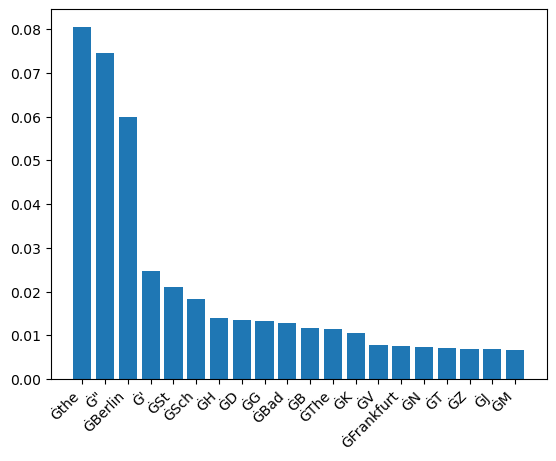

In [11]:
plt.bar(top_predicted_words, top_predicted_probs.detach().numpy())
plt.xticks(rotation=45, ha='right')
plt.show()

Using this infrastructure, it is easy to compute the negative log probability (their surprisal) of sentences and use it as a way of measuring the model's knowledge of different aspects of grammar. The `get_log_prob` function defined below takes in a sentence or list of sentences and returns the probability of each (and optionally a graph of the surprisal of each word). 

In [ ]:
def get_log_prob(sentences, graph=True):
    if isinstance(sentences,str): 
        sentences = [sentences]
    for i, s in enumerate(sentences):
        s_orig = s
        if model_name == 'openai-community/gpt2':
            s = tokenizer.bos_token + " " + s
        encoded_input = tokenizer(s, return_tensors='pt')
        output = model(**encoded_input, labels=encoded_input["input_ids"])    
        logits = output.logits[:,:,:].squeeze()
        probs = F.log_softmax(logits,dim=1).detach()
        targets = encoded_input['input_ids'][0][1:]
        token_list = tokenizer.convert_ids_to_tokens(targets)
        token_list = [t[1:] if t.startswith("Ġ") or t.startswith("▁") else "-"+t for t in token_list]
        log_prob = 0
        prob_list = []
        for pos, id in enumerate(targets):
            prob = probs[pos, id]            
            log_prob -= prob
            prob_list += [-prob]
        if graph:
            x = range(len(token_list))
            plt.plot(x, prob_list)
            for i,j in zip(x, prob_list):
                j = j.item()
                plt.annotate(token_list[i], xy = (i, j))
        print(s_orig)
        print("NLL:", float(log_prob))
    if graph:
        plt.xlabel("Position")
        plt.ylabel("Surprisal")
        plt.show()

The following comparison shows that the model has higher surprisal on the sentence with the incorrectly agreeing verb form, and that the higher surprisal occurs at the point of the (incorrect) verb.

In [ ]:
get_log_prob(['The label on the bottles is torn', 'The label on the bottles are torn'], graph=True)

Intrestingly, though, we see that in the presence of an intervening distractor noun with agreement features that are distinct from those of the subject, the surprisal of the incorrect verb form is increased, suggesting that this (incorrectly) increases the model's acceptability of incorrect agreement:  

In [ ]:
get_log_prob(['The label on the bottle are torn', 'The label on the bottles are torn'], graph=True)


As we have discussed, one can also analyze the internal functioning of language models. Above, I pointed out how you can get access to the hidden unit activations and attention weights, by adding arguments when you load the model. There are also a number of packages that have been developed that facilitate this kind of analysis, including [minicons](https://github.com/kanishkamisra/minicons), [diagNNose](https://github.com/i-machine-think/diagNNose) and [captum](https://captum.ai). 


So far we have been dealing only with decoder-only models. The `transformers` package also provides access to encoder-only transformers, like BERT, which have been trained to perform masked language modeling. These can be loaded with the `AutoModelForMaskedLM` class.`

In [ ]:
from transformers import AutoModelForMaskedLM

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')

We can now carry out masked language modeling with this model by including the `[MASK]` token in the input sentence. By locating the position of the `[MASK]` token in the input sequence, we can find the logits associated with the masked token and extract the probabilities for each possible word at this position.

In [ ]:
input = "the capital of [MASK] is called Berlin."   
encoded_input = bert_tokenizer(input, return_tensors='pt')
output = bert_model(**encoded_input)
logits = output.logits[:,:,:].squeeze()
probs = F.softmax(logits,dim=1).detach()

mask_pos = encoded_input['input_ids'][0].tolist().index(bert_tokenizer.mask_token_id)
print(mask_pos)



Now we can look at BERT's guess at the 10 most likely words to fill this slot.

In [ ]:
top_predicted_probs, top_predicted_words = torch.topk(probs[mask_pos], 10)
top_predicted_words = bert_tokenizer.convert_ids_to_tokens(top_predicted_words)
plt.bar(top_predicted_words, top_predicted_probs.detach().numpy())
plt.xticks(rotation=45, ha='right')
plt.show()

#### Exercise: 

Using some of the techniques described above, your task is to examine a language model's knowledge of a grammatical phenomenon of your choice. To do that, you will need to construct sets of examples which differ along relevant dimensions, and then examine model behavior on these examples. You should explore surprisal values, either for the entire sentence or for the individual words to determine whether the model is sensitive to the relevant grammatical distinctions. You may also want to look at patterns of attention, or explore the hidden activation vectors by training diagnostic classifiers (or some other method).  

You are free to explore a phenomenon we talked about in class or something which we did not discuss. And you can look at phenomenon in English or in some other language. In the latter case, you will need to make use of a language model that has been trained with data from that language. You can either find a model for the specific language of interest or use a multi-lingual model, such as `xglm` or `mGPT`. See the list of models available [here](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending), where you can also filter by languages (using the Languages tab on the top left).

### Part 2: Fine-tuning a Pretrained Model

Now, we will explore how you can fine-tune a pretrained model to perform a specific task. We will once again make use of the `transformers` library, this time to fine-tune a pretrained model on the [CoLA dataset](https://nyu-mll.github.io/CoLA/), which consists of sentences annotated for grammaticality. (We are following the example provided [here](https://coe-379l-sp24.readthedocs.io/en/latest/unit04/fine_tuning_transformers.html), so you can refer to that page for more details.)

To start off, we will load some useful classes and functions, and set up the device to use for training (so that we can use the GPU if it is available).

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from evaluate import load
import torch
import datasets
import numpy as np

if torch.backends.mps.is_built():
    device = torch.device("mps") 
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

We now load a pretrained model and tokenizer. Here, we will use the `distilbert-base-uncased` model, which is a smaller version of the BERT model. We will load these in a similar way to what we did above, but this time we will use the `AutoModelForSequenceClassification` class, which loads the distilbert model together with an as-yet untrained classifier MLP "head"  that takes the model's final hidden states and maps them to logits for two classes (which will correspond to grammatical and ungrammatical sentences). (Note that if you are interested in fine-tuning a model for a different task, you can use a different AutoModel class. See the [documentation](https://huggingface.co/transformers/model_doc/auto.html) for more details.)

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

You can examine the structure of the model by printing it:

In [ ]:
model

We next need to load a dataset, using infrastructure provided by the `transformers` package. We will make use of the `glue` dataset available from the `datasets` library, which provides a simple API for loading and working with a number of datasets that have been used to evaluate NLP models. From `glue`, we will load the `cola` dataset.  The `cola` dataset provides a split of the data into training, validation and test sets.

In [ ]:
dataset = datasets.load_dataset("glue", "cola")
dataset

Each item in this dataset includes three components: a string corresponding to the sentence to be evaluated,  a label corresponding to whether the sentence is grammatical (1) or ungrammatical (0), and an index corresponding to the number of the example.

In [ ]:
dataset['train'][42]

We can now tokenize the sentences in the dataset using the tokenizer we loaded above. This will produce a dataset that  includes `input_ids` and `attention_mask` fields for each example. We will also truncate the sentences to a maximum length and use a DataCollator object to pad the sentences to the same length.

In [ ]:
def preprocess(sample):
    return tokenizer(sample["sentence"], truncation=True)

tokenized_datasets = dataset.map(preprocess, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Next we define a function that specifies how to compute accuracy on the dataset. This function will be used to determine the model's performance.

In [ ]:
metric = load('glue', 'cola')

def compute_metrics(preds):
    logits, labels = preds
    predictions = np.argmax(np.asarray(logits), axis=-1)
    return metric.compute(predictions=predictions, references=labels)

To train our model, we use the [Trainer API](https://huggingface.co/docs/transformers/en/main_classes/trainer). This is a high-level API that abstracts away the training loop.  It is designed to be easy to use, but also to be highly customizable. We first specify the traiing arguments, and then use them to create a Trainer object.

In [ ]:

batch_size = 16 # can experiment with different sizes

args = TrainingArguments(
    f"distilbert-finetuned-cola", # directory to save the model
    eval_strategy = "epoch", # evaluate after each epoch
    save_strategy = "epoch", # save after each epoch
    learning_rate=2e-5, # the learning rate to use
    per_device_train_batch_size=batch_size, # the batch size
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3, # number of epochs; 5 took about 30 minutes
    weight_decay=0.01,
    load_best_model_at_end=True,
#    use_mps_device=True,
    metric_for_best_model="matthews_correlation" # metric associated with COLA GLUE
)

trainer = Trainer(
    model,  # the pre-trained model
    args,  # the TrainingAgruments, defined above
    train_dataset=tokenized_datasets["train"], # the training dataset
    eval_dataset=tokenized_datasets["validation"], # the validation dataset
    processing_class=tokenizer, # our tokenizer
    data_collator=data_collator, # the collator we defined above
    compute_metrics=compute_metrics # our function for computing the metrics
)

Now we fine-tune the model using the `train` method of the Trainer object. This may take some time, depending on the size of the model, the number of epochs you specify, and the speed of your machine.

In [ ]:
trainer.train()

Finally, we evaluate the model on the validation set to see how well it performs. (Note that we do not use the test set for this because no labels are provided for the test set.) The trainer object itself provides an `evaluate` method that can be used to evaluate the model on the validation set.

In [ ]:
trainer.evaluate()

The CoLA dataset uses the Matthews correlation as its measure of performance. This is a measure of the quality of binary classifications that is particularly useful when the classes are imbalanced. We can however also compute the accuracy of the model on the validation set, by looking at the number of cases on which the model's output matches the true label.

In [ ]:
from tqdm import tqdm 
correct = 0
for s, l in tqdm(zip(tokenized_datasets['validation']['sentence'], tokenized_datasets['validation']['label'])):
    encoded_input = tokenizer(s, return_tensors='pt').to(device)
    output = model(**encoded_input)
    if torch.argmax(output['logits'], dim=-1) == l:
        correct += 1
print(f"Validation accuracy: {(100*correct/len(tokenized_datasets['validation'])):.2f}%")

We can also test model behavior on a few examples:

In [ ]:
def predict(sentence):
    encoded_input = tokenizer(sentence, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return torch.argmax(output['logits'], dim=-1).item()

sentences = ["The boys are happy.", "The boys is happy.", "The boys in the house are happy.", "The boys in the house is happy."]
for s in sentences:
    print(f"{s} -> {predict(s)}")

#### Exercise: 

Experiment with fine-tuning using other models (including other encoder-only models like BERT or RoBERTa, but also decoder-only models like GPT-2) and different tasks/datasets in the GLUE dataset (for example, NLI with the MNLI dataset, sentiment analysis with SST-2, or paraphrase detection with MRPC). You can also experiment with different hyperparameters, including the learning rate, the number of epochs, or the batch size, or look at different ways of converting model output to a response for the task.